# Práctica de Calibración de cámaras

Máster Universitario en Visión Artificial, URJC <br>
Visión Tridimensional 2020-21 <br>
Practica 1. Marzo de 2021

Este enunciado está en el archivo "PracticaCalib2021_Alumnos.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Una secuencia de imágenes tomadas con una cámara de móvil en alta resolución en el directorio ``template4``.
* Un conjunto de imágenes de un edificio tomadas con el mismo móvil y resolución, ``building``.

## Condiciones

* La fecha límite de entrega será el viernes 16 de abril de 2021 a las 23:55 (en el Aula Virtual)
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``template4``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 21.5 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
#%matplotlib notebook
import cv2
# import glob # [no version for my python, use pathlib instead]
from pathlib import Path
import copy
import numpy as np
# import scipy.misc as scpm # scipy.misc.imread deprecated [https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.misc.imread.html]
import imageio
import matplotlib.pyplot as plt

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una tupla con el primer elemento consistente en la lista de matrices de NumPy con las imágenes leídas y el segundo elemento la lista de nombres de fichero correspondientes.

In [2]:
p = Path('.')
template4 = "./template4/" # path where template4 dir is
filenames = sorted(list(p.glob(template4 + "*.jpg")))

In [3]:
def load_images(filenames):
    imgs = []
    for file in filenames:
        imgs.append(imageio.imread(file)) # load in RGB
    return imgs

Usa ``load_images`` para cargar todas las imágenes del directorio ``template4`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [4]:
imgs = load_images(filenames)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (9, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.

In [5]:
corners = [cv2.findChessboardCorners(img, (9,6)) for img in imgs]

In [6]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
corners2 = copy.deepcopy(corners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
cornersRefined = [cv2.cornerSubPix( cv2.cvtColor(imgs[i],cv2.COLOR_RGB2GRAY), corners2[i][1], (11,11), (-1,-1), criteria) for i in range(len(corners2) )]

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [7]:
imgs2 = copy.deepcopy(imgs)

for i in range(len(imgs2)):
    if corners[i][0]:
        cv2.drawChessboardCorners(imgs2[i], (9,6), cornersRefined[i], corners[i][0]) 

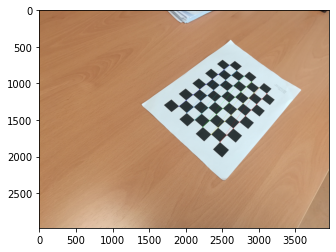

In [8]:
plt.imshow(imgs2[0])

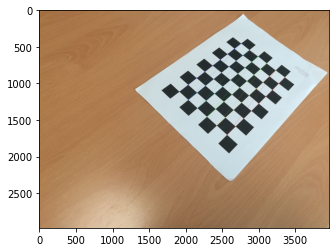

In [9]:
plt.imshow(imgs2[1])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (9, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 21.5 mm.

In [10]:
def get_chessboard_points(chessboard_shape, dx, dy):
    y,x = chessboard_shape
    n_corners = x*y
    cb_points = np.zeros((n_corners,3))
    count = 0
    for i in range(x):
        for j in range(y):
            cb_points[count][0], cb_points[count][1]  = i * dx, j * dy
            count += 1
    del count
    return cb_points

cb_points = get_chessboard_points((9, 6), 21.5, 21.5)
print(cb_points)

[[  0.    0.    0. ]
 [  0.   21.5   0. ]
 [  0.   43.    0. ]
 [  0.   64.5   0. ]
 [  0.   86.    0. ]
 [  0.  107.5   0. ]
 [  0.  129.    0. ]
 [  0.  150.5   0. ]
 [  0.  172.    0. ]
 [ 21.5   0.    0. ]
 [ 21.5  21.5   0. ]
 [ 21.5  43.    0. ]
 [ 21.5  64.5   0. ]
 [ 21.5  86.    0. ]
 [ 21.5 107.5   0. ]
 [ 21.5 129.    0. ]
 [ 21.5 150.5   0. ]
 [ 21.5 172.    0. ]
 [ 43.    0.    0. ]
 [ 43.   21.5   0. ]
 [ 43.   43.    0. ]
 [ 43.   64.5   0. ]
 [ 43.   86.    0. ]
 [ 43.  107.5   0. ]
 [ 43.  129.    0. ]
 [ 43.  150.5   0. ]
 [ 43.  172.    0. ]
 [ 64.5   0.    0. ]
 [ 64.5  21.5   0. ]
 [ 64.5  43.    0. ]
 [ 64.5  64.5   0. ]
 [ 64.5  86.    0. ]
 [ 64.5 107.5   0. ]
 [ 64.5 129.    0. ]
 [ 64.5 150.5   0. ]
 [ 64.5 172.    0. ]
 [ 86.    0.    0. ]
 [ 86.   21.5   0. ]
 [ 86.   43.    0. ]
 [ 86.   64.5   0. ]
 [ 86.   86.    0. ]
 [ 86.  107.5   0. ]
 [ 86.  129.    0. ]
 [ 86.  150.5   0. ]
 [ 86.  172.    0. ]
 [107.5   0.    0. ]
 [107.5  21.5   0. ]
 [107.5  43. 

**Ejercicio 4.** Calibra la cámara usando la lista de resultados de ``cv2.findChessboardCorners`` y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior. 

In [11]:
# Extract the list of valid images with all corners
valid_corners = [(imgs[i], cornersRefined[i]) for i in range(len(cornersRefined)) if corners[i][0]]
num_valid_images = len(valid_corners)
number_of_points = 9*6

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.empty((num_valid_images, number_of_points, 3), dtype=np.float32)
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.empty((num_valid_images, number_of_points, 2), dtype=np.float32)

object_points[:,:,:] = cb_points

for i in range(len(valid_corners)):
    image_points[i,:,:] = cornersRefined[i].reshape(number_of_points,2)

# Calibrate for square pixels corners standard
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, valid_corners[0][0].shape[:-1], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:\n", dist_coeffs)
print("rms:\n", rms)

Corners standard intrinsics:
 [[3.20506009e+03 0.00000000e+00 1.97863570e+03]
 [0.00000000e+00 3.20506009e+03 1.45074623e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Corners standerd dist_coefs:
 [[ 3.20092199e-01 -2.42383771e+00 -4.31191915e-05 -5.72026118e-03
   4.92410794e+00]]
rms:
 1.8417054988755082


Presta atención al parámetro de salida ``rms`` ¿qué significa este parámetro? ¿Se obtiene un valor razonable? ¿Qué pasa con el ``rms`` y la matriz de intrínsecos ``K`` si calibramos con las mismas imágenes pero con un tamaño de 1/4 del ancho y del alto? 

rms es error cuadrado medio. 

In [12]:
# Calibrate for square pixels corners standard

rows, cols = valid_corners[0][0].shape[:-1]
rms2, intrinsics2, dist_coeffs2, rvecs2, tvecs2 = cv2.calibrateCamera(object_points, image_points, (rows//4, cols//4), None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics2)
print("Corners standerd dist_coefs:\n", dist_coeffs2)
print("rms:\n", rms2)

Corners standard intrinsics:
 [[4.75226010e+03 0.00000000e+00 9.13203618e+02]
 [0.00000000e+00 4.75226010e+03 4.66992295e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Corners standerd dist_coefs:
 [[-0.26296445  0.587915   -0.02584233 -0.03349094 -0.57354033]]
rms:
 5.0353547523930775


El error aumenta casi por un factor de 4

**Ejercicio 5.** Implementa una función ``plotCamera3D(K, rvec, tvec, axes)`` que dibuje los ejes del sistema de referencia de la escena en 3D, el centro óptico de la cámara como un punto 3D y los ejes del sistema de referencia de la cámara expresados en el de la escena. A esta función se le pasan los intrínsecos (matriz $3x3$), y los extrínsecos: el vector de rotación ``rvec`` ($3x1$), y el vector de traslación ``tvec`` ($3x1$). El parámetro ``axes`` son los ejes de matplotlib configurados para dibujar en 3D. 

In [13]:
d = 21.5*3

def plot3DPoints(Pts, axes):
    
    x = Pts[:, 0]
    y = Pts[:, 1]
    z = Pts[:, 2]
    axes.scatter3D(x, y, z, 'k')  
    
    # se pintan los ejes del sistema de referencia del plano
    axes.plot3D((0,d), (0,0), (0,0), '-r', linewidth=3)
    axes.plot3D((0,0), (0,d), (0,0),'-g', linewidth=3)
    axes.plot3D((0,0), (0,0), (0,d),'-b', linewidth=3)
    
def plotCamera3D(K, rvec, tvec, axes=None):
    
    if axes is None:
        axes = plt.axes(projection = '3d')
        
    # Para poder mover el punto de vista en la ventana 3D interactivamente, hay que descomentar "%matplotlib tk" 
    # habrá que usar axes.scatter3d y/o axes.plot3d  
    
    # Se desempaquetan en 1 array
    rvec = rvec.ravel()
    tvec = tvec.ravel()
    
    # Matriz de Rotacion y Proyeccion
    R, _ = cv2.Rodrigues(rvec) # ortonormal
    #P = np.dot(intrinsics, np.hstack((R, tvecs[image_index])) )
    
    # Centro optico de la camara. ref: diapos
    Cesc = (-R.T @ tvec).ravel()
    cx, cy, cz = Cesc[0], Cesc[1], Cesc[2]
    
    axes.scatter3D(cx, cy, cz)
    
    # Vectores ejes del sistema de referencia del plano en ejes escena
    m1 = np.array([d,0,0]).T
    m2 = np.array([0,d,0]).T
    m3 = np.array([0,0,d]).T
    
    
    # ejes rotados y trasladados en ejes escena
    m1r = R.T@m1 + Cesc
    m2r = R.T@m2 + Cesc
    m3r = R.T@m3 + Cesc
    
    # Comprobación eje x con matriz de cambio de base de escena a camara
#     m1esc = np.append(m1r,[1])
#     M = np.vstack((np.column_stack((R, -R@Cesc)),[0,0,0,1]))
#     print("Comprobación\nCoord m1 en camaras\nDebería ser igual a E1:", M@m1esc)
#     print("coord m1 en escena:", m1r)
#     print("coord E1 en escena:", m1)
    
    #Dibujar ejes rotados en centro optico en ejes escena
    axes.plot3D((cx,m1r[0]), (cy,m1r[1]), (cz,m1r[2]), '-r', linewidth=3)
    axes.plot3D((cx,m2r[0]), (cy,m2r[1]), (cz,m2r[2]),'-g', linewidth=3)
    axes.plot3D((cx,m3r[0]), (cy,m3r[1]), (cz,m3r[2]),'-b', linewidth=3)

In [14]:
tvecs[0].ravel()

array([ -9.34414576, -20.38876329, 471.38500635])

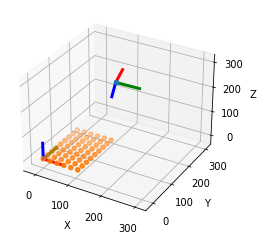

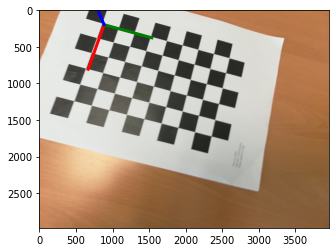

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Cambiar para una imagen de calibración diferente
image_index = -1
plt.figure()
axes = plt.axes(projection='3d')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')

plotCamera3D(intrinsics, rvecs[image_index], tvecs[image_index], axes)
plot3DPoints(cb_points, axes) # pintar esquinas del "ajedrez" en 3D

# Importante para que los ejes 3D tengan las mismas proporciones en 
# matplotlib
scaling = np.array([getattr(axes, 'get_{}lim'.format(dim))() for dim in 'xyz']); axes.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

# Mostrar resultados en 3D
#ref: clase
plt.show()

R, _ = cv2.Rodrigues(rvecs[image_index])
P = np.dot(intrinsics, np.hstack((R, tvecs[image_index])) )

points3D = np.array([ 
    [d, 0, 0, 1],
    [0, 0, 0, 1],
    [0, d, 0, 1],
    [0, 0, 0, 1],
    [0, 0, d, 1],
    [0, 0, 0, 1]
]).T

points2D = P @ points3D
points2D = points2D / points2D[2,:]

plt.figure()

plt.plot(points2D[0,0:2], points2D[1,0:2], '-r', linewidth=3)
plt.plot(points2D[0,2:4], points2D[1,2:4], '-g', linewidth=3)
plt.plot(points2D[0,4:6], points2D[1,4:6], '-b', linewidth=3)

plt.imshow(imgs[image_index])
plt.show()

Usando la función desarrollada, ``plotCamera3D``, pintar en 3D los ejes del sistema de referencia de la escena, los puntos de la plantilla de calibración y todas las cámaras que tomaron las imágenes en ``template4``.

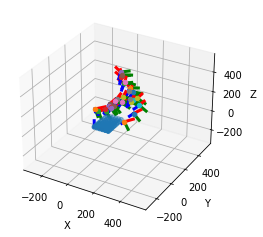

In [16]:
plt.figure()
axes = plt.axes(projection='3d')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')
plot3DPoints(cb_points, axes) # pintar esquinas del "ajedrez" en 3D

# se representan las camaras en las que se detectó la plantilla
for image_index in range(len(valid_corners)):
    plotCamera3D(intrinsics, rvecs[image_index], tvecs[image_index], axes)

scaling = np.array([getattr(axes, 'get_{}lim'.format(dim))() for dim in 'xyz']); axes.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
plt.show()

###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 6.** Conociendo los intrínsecos K y el tamaño en píxeles de la imagen, calcula el ángulo de visión horizontal de la cámara (el relacionado con el ancho de la imagen).


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

In [17]:
# En la matriz K, los parametros de la diagonal, relacionan la focal y los pixels.
au, av = intrinsics[0,0], intrinsics[1,1]
alto, ancho = imgs[0].shape[:-1]

campo_hor = 2*np.rad2deg(np.arctan( (0.5*ancho) / av))
campo_ver = 2*np.rad2deg(np.arctan( (0.5*alto) / au))

print("Campo de visión horizontal:", campo_hor)
print("Campo de visión vertical:", campo_hor)

Campo de visión horizontal: 63.51676776608797
Campo de visión vertical: 63.51676776608797


**Ejercicio 7.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (15,15) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagona.l que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

In [18]:
# IDEA
# Producto escalar entro dos rayos: uno que pase en por punto y otro por punto2
# Despues se obtiene el ángulo
punto = np.array([15,15])
region = np.array([50, 50])
punto2 = punto + region

# referencia centro_img será (0,0)
fpx = intrinsics[0,0] #Distancia focal en pixeles
centro_img = imgs[0].shape[:-1]
centro_img = np.array([centro_img[0]//2, centro_img[1]//2])

# puntos respecto a centro_img
punto = centro_img - punto
punto = np.append(punto, fpx)

punto2 = centro_img - punto2
punto2 = np.append(punto2, fpx)

centro_img = np.array([0,0,0])

#Vectores
v1 = punto - centro_img
v2 = punto2 - centro_img

# producto escalar
pesc = np.inner(v1,v2)

# Ángulo entre el punto 15,15 y 65,65
ang = np.rad2deg( np.arccos( pesc / ( np.linalg.norm(v1)*np.linalg.norm(v2) ) ) )
print("El ángulo en grados diagolal de visión entre (15,15) y (65,65) es:",ang)

El ángulo en grados diagolal de visión entre (15,15) y (65,65) es: 0.808924351641812


**Ejercicio 8.** En las imágenes tomadas por dispositivos digitales se almacena información sobre la cámara que tomó la foto en un formato denominado [EXIF](https://es.wikipedia.org/wiki/Exchangeable_image_file_format). Esta información se puede leer con programas de retoque fotográfico libres como [GIMP](https://www.gimp.org/downloads/).

Dados los intrísecos en K del proceso de calibración, y sabiendo que el móvil que tomó la foto es un modelo Honor 6X con un sensor Sony IMX386 Exmor RS calcular la focal en mm de la cámara a partir de K. Se pide comparar el resultado con la información EXIF de las imágenes.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

In [19]:
# hay que calcular la focal en mm a partir de la focal en pixeles y el tamaño del pixel en el sensor

#ref: https://en.wikipedia.org/wiki/Exmor
tamano_pixel = 0.00125 #mm

# Segun GIMP en Exif.Photo.FocalLenght
exif = 3.8

focal = au*tamano_pixel
print("Focal en mm calculado: ", focal)
print("Focal en mm según EXIF según GIMP: ", exif)
print("Focal en mm según Propiedades/Detalles de Windows: ", 4)

Focal en mm calculado:  4.006325114104031
Focal en mm según EXIF según GIMP:  3.8
Focal en mm según Propiedades/Detalles de Windows:  4


**Ejercicio 9.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``IMG_20201019_141223.jpg``  y ``IMG_20201019_141235_1.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

In [20]:
def calcOpticCenter(K, rvec, tvec):
    # Se desempaquetan en 1 array
    rvec = rvec.ravel()
    tvec = tvec.ravel()
    
    # Matriz de Rotacion y Proyeccion
    R, _ = cv2.Rodrigues(rvec) # ortonormal
    
    # Centro optico de la camara. ref: diapos
    Cesc = (-R.T @ tvec).ravel()
    return Cesc

In [21]:
# comprobar tamaños de array
print(len(filenames) == len(valid_corners))

# indices de la imagen con la que corresponde
im1 = 0
im2 = 11

# obtener los centros optinos respecto a la escena y calcular la diferencia
c1 = calcOpticCenter(intrinsics, rvecs[im1], tvecs[im1])
c2 = calcOpticCenter(intrinsics, rvecs[im2], tvecs[im2])

diff = c2-c1

print("Movimiento en 3D:", diff)
print("Movimiento total en mm:", np.linalg.norm(diff))

True
Movimiento en 3D: [-26.32196819 407.79483247 -19.16846682]
Movimiento total en mm: 409.0927786238979


## 2. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 10.** Se desea estimar los intrínsecos de la cámara a partir de una imagen (cualquiera de las imágenes en ``building``).

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico. Comparar el resultado con la K obtenida calibrando la cámara con el algoritmo de OpenCV.

Sugerencia: Localizar direcciones ortogonales en la escena y sus puntos de fuga asociados.

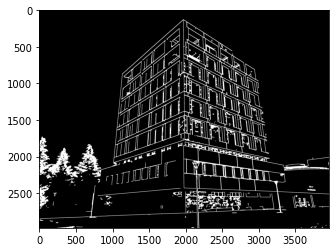

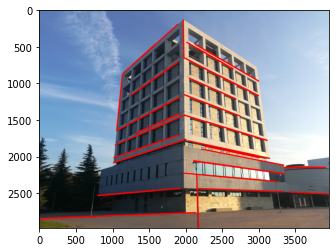

In [22]:
# Se lee la imagen
im_build = cv2.imread("./building/build_001.jpg")
gray = cv2.cvtColor(im_build, cv2.COLOR_BGR2GRAY)

# plt.figure()
# plt.imshow(gray, cmap='gray')
# plt.show()

# Canny ref: https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
ratio = 3
kernel_size = 13
low_threshold = 40
kernel = np.ones((5,5),np.uint8)

img_blur = cv2.blur(gray, (3,3))
detected_edges = cv2.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)

# Algunas operaciones morfológicas
dilated = cv2.dilate(detected_edges,kernel,iterations = 1)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opening, cmap='gray')

im_lines = im_build.copy()

# Hough transform ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(opening,1,np.pi/180,100,100,50)

if lines is not None:
    final_lines = []
    min_len = 500
    # se guardaran las líneas que midan más de 500 pixeles
    for i in range(0, len(lines)):
        x1,y1,x2,y2 = lines[i][0]
        lenth = np.sqrt( (x2-x1)**2 + (y2-y1)**2 )
        if lenth > min_len:
            cv2.line(im_lines,(x1,y1),(x2,y2),(0,0,255),15)
            m = np.rad2deg(np.arctan((y2-y1)/(x2-x1)))
            final_lines.append((lines[i], lenth, m))

plt.figure()
plt.imshow(cv2.cvtColor(im_lines, cv2.COLOR_BGR2RGB), cmap='gray')

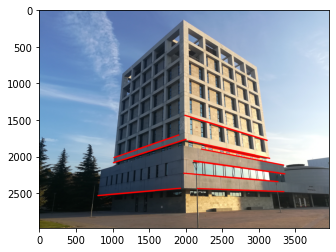

In [23]:
# Nos quedamos con las líneas que tengan una pendiente absoluta menor a 20 grados y estén centradas en la imagen
hor_lines = [line for line in final_lines if abs(line[2])<20 and line[0][0][2] < 3500 and line[0][0][0] > 500 and line[0][0][3] < 2700]

horim = im_build.copy()
for line in hor_lines:
    x1,y1,x2,y2 = line[0][0]
    cv2.line(horim,(x1,y1),(x2,y2),(0,0,255),15)

plt.figure()
plt.imshow(cv2.cvtColor(horim, cv2.COLOR_BGR2RGB))

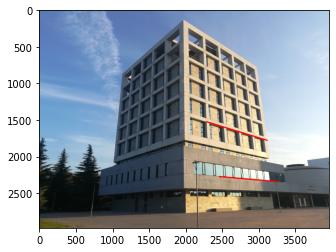

In [24]:
# separamos a mano dos lineas que miren a derechas
hor_lines_der = [hor_lines[16],hor_lines[9]]

horimr = im_build.copy()
for line in hor_lines_der:
    x1,y1,x2,y2 = line[0][0]
    cv2.line(horimr,(x1,y1),(x2,y2),(0,0,255),15)

plt.figure()
plt.imshow(cv2.cvtColor(horimr, cv2.COLOR_BGR2RGB))

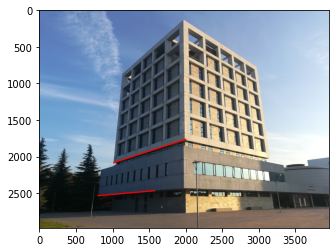

In [25]:
# separamos a mano dos lineas que miren a izquierdas
hor_lines_izda = [hor_lines[5],hor_lines[13]]

horimz = im_build.copy()
for line in hor_lines_izda:
    x1,y1,x2,y2 = line[0][0]
    cv2.line(horimz,(x1,y1),(x2,y2),(0,0,255),15)

plt.figure()
plt.imshow(cv2.cvtColor(horimz, cv2.COLOR_BGR2RGB))

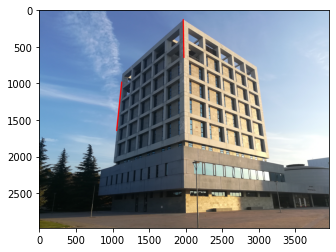

In [26]:
# Nos quedamos con las líneas que tengan una pendiente de unos 85-95 grados
vertical_lines = [line for line in final_lines if abs(line[2])>80 and abs(line[2])<100]
# Se seleccionan a mano dos lineas
vertical_lines = [vertical_lines[2], vertical_lines[3]]

vert = im_build.copy()
for line in vertical_lines:
    x1,y1,x2,y2 = line[0][0]
    cv2.line(vert,(x1,y1),(x2,y2),(0,0,255),15)

plt.figure()
plt.imshow(cv2.cvtColor(vert, cv2.COLOR_BGR2RGB))

In [27]:
def intersertLines(l1,l2):
    l1x1,l1y1,l1x2,l1y2 = l1[0][0]
    l2x1,l2y1,l2x2,l2y2 = l2[0][0]
    
    m1 = (l1y2 - l1y1)/(l1x2 - l1x1)
    m2 = (l2y2 - l2y1)/(l2x2 - l2x1)
    
    b1 = - m1*l1x1 + l1y1
    b2 = - m2*l2x1 + l2y1
    
    l1 = np.array([ m1, -1, b1])
    l2 = np.array([ m2, -1, b2])
    
    p = np.cross(l1,l2)
    return p/p[2]

In [28]:
# se calculan los puntos de fuga sobre la imagen en pixeles
fuga_vertical = intersertLines(*vertical_lines)
fuga_hor1 = intersertLines(*hor_lines_izda)
fuga_hor2 = intersertLines(*hor_lines_der)
print(fuga_hor1, fuga_hor2, fuga_vertical)

[-8.00711862e+02  2.67443240e+03  1.00000000e+00] [5.64519792e+03 2.54928270e+03 1.00000000e+00] [ 1.86539993e+03 -6.06298192e+03  1.00000000e+00]


In [29]:
def plot_line(l, plot_string='-y'):
    r = 6000
    if (l[1] != 0):
        xx = np.arange(-2000,r,0.1)
        yy = (-l[0]/l[1])*xx - (l[2]/l[1])
    else:
        yy = np.arange(-2000,r,0.1)
        xx = (-l[1]/l[0])*yy - (l[2]/l[0])

    plt.plot(xx, yy, plot_string)

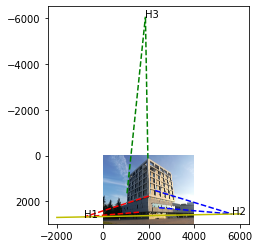

In [30]:
# dibujamos los puntos de fuga 
fuga = im_build.copy()
plt.figure()
plt.imshow(cv2.cvtColor(fuga, cv2.COLOR_BGR2RGB))


x_fuga_v = int(fuga_vertical[0])
y_fuga_v = int(fuga_vertical[1])

plt.annotate("H3", (x_fuga_v, y_fuga_v))

for line in vertical_lines:
    x1,y1,x2,y2 = line[0][0]
    plt.plot([x1,x_fuga_v],[y1,y_fuga_v], "--g")

x_fuga_h1 = int(fuga_hor1[0])
y_fuga_h1 = int(fuga_hor1[1])

plt.annotate("H1", (x_fuga_h1, y_fuga_h1))

for line in hor_lines_izda:
    x1,y1,x2,y2 = line[0][0]
    plt.plot([x2,x_fuga_h1],[y2,y_fuga_h1], "--r")

x_fuga_h2 = int(fuga_hor2[0])
y_fuga_h2 = int(fuga_hor2[1])

plt.annotate("H2", (x_fuga_h2, y_fuga_h2))
    
for line in hor_lines_der:
    x1,y1,x2,y2 = line[0][0]
    plt.plot([x1,x_fuga_h2],[y1,y_fuga_h2], "--b")

# linea horizonte
lh = np.cross(fuga_hor1, fuga_hor2)

# se dibuja la linea del horizonte
plot_line(lh/lh[2])

In [31]:
# por seguir la notacion
v1, v2, v3 = fuga_hor1, fuga_hor2, fuga_vertical

In [32]:
from sympy import Matrix, linsolve, symbols, latex

# variables simbólicas que hacen referencia a w1, w4, w5
x, y, z = symbols("x, y, z", real=True)

v1 = Matrix(v1)
v2 = Matrix(v2)
v3 = Matrix(v3)

w = Matrix([
    [x, 0, y],
    [0, x, z],
    [y, z, 1]
])

# se plantea el sistema de ecuaciones
eq1 = v1.T @ w @ v2
eq2 = v1.T @ w @ v3
eq3 = v2.T @ w @ v3

# se resuelve
Eqns = [eq1[0], eq2[0], eq3[0]]
sol = linsolve(Eqns, [x, y, z])

w1 = sol.args[0][0]
w4 = sol.args[0][1]
w5 = sol.args[0][2]

# se construye la matriz numérica w
w = np.array([
    [w1, 0, w4],
    [0, w1, w5],
    [w4, w5, 1]
], dtype=np.float32)

# se comprueba la ortogonalodad de los puntos de fuga
print("Deberíamos obtener escalares cercanos a 0 debido al calculo numérico")
print(v1.T @ w @ v2)
print(v1.T @ w @ v3)
print(v2.T @ w @ v3)

Deberíamos obtener escalares cercanos a 0 debido al calculo numérico
Matrix([[5.19505016782773e-8]])
Matrix([[-5.65891945525365e-8]])
Matrix([[1.43078182635037e-8]])


In [33]:
w

array([[ 6.6804439e-08,  0.0000000e+00, -1.3434909e-04],
       [ 0.0000000e+00,  6.6804439e-08, -9.6223608e-05],
       [-1.3434909e-04, -9.6223608e-05,  1.0000000e+00]], dtype=float32)

In [34]:
# To do Cholesky-Decomposition ref: https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/
import scipy
import scipy.linalg

L = scipy.linalg.cholesky(w, lower=True)
U = scipy.linalg.cholesky(w, lower=False)

k = np.linalg.inv(U)
k = k/k[2,2]
k

array([[2.9748838e+03, 0.0000000e+00, 2.0110802e+03],
       [0.0000000e+00, 2.9748838e+03, 1.4403773e+03],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [35]:
intrinsics

array([[3.20506009e+03, 0.00000000e+00, 1.97863570e+03],
       [0.00000000e+00, 3.20506009e+03, 1.45074623e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Observaciones
No da un resultado igual al utilizado en la primera parte, pero sí las órdenes de magnitud son correctas. 
Ha un error de:

In [36]:
intrinsics - k

array([[230.17630222,   0.        , -32.44450112],
       [  0.        , 230.17630222,  10.36891351],
       [  0.        ,   0.        ,   0.        ]])

Esto se deberá fundamentalmente a la mala localización de los puntos de fuga al usar la transformada de Hough, se aprecia que la línea del infinito no es paralela al borde de la imagen. Posiblemente mejorando la obtención de los puntos de fuga, el error dismunuiría.